# Final notebook used to obtain fiducial IA signal

In [535]:
import pyccl as ccl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import simps
from scipy.interpolate import interp1d
from importlib import reload
import cmasher as cmr
from more_itertools import locate

import CM_code.halo_model as halos 
import CM_code.spurious_george as sp

reload(sp)
reload(halos)

year=1

zlmin, zlmax = 1.0, 1.2
zsmin, zsmax = 0.05, 3.5

out_plot = 'mbias_forecast_y%d_zs=%1.2f-%1.1f.png'%(year, zsmin, zsmax)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### Initial set up is the same as in the GI / II case

In [536]:
cosmo = halos.cosmo_SRD

k_arr = np.geomspace(1E-4, 5E5, 3000)

a_arr = np.linspace(0.1,1,32)

In [537]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Bhattacharya 2013 concentration-mass relation (used in LSST SRD)
cM = ccl.halos.ConcentrationBhattacharya13(hmd_200m)

# The Tinker 2010 mass function
nM = ccl.halos.MassFuncTinker10(cosmo, mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

# Halo model calculator for computing mass integrals
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m, nlog10M=64)

In [538]:
if year == 1:
    fred = 0.1
elif year == 10:
    fred = 0.05

# red gal ampltiude
a1h_r = 0.001

#blue gal amplitude
a1h_b = 0.0006

a1h = np.average([a1h_r, a1h_b],weights=[fred,(1-fred)])

print(a1h)

# create a sattelite shear HOD based on perscription of Fortuna 2021
sat_gamma_HOD = ccl.halos.SatelliteShearHOD(cM, a1h=a1h, b=-2)

0.00064


In [539]:
# NFW profile for matter (G)
NFW =  ccl.halos.HaloProfileNFW(cM, truncated=True, fourier_analytic=True)

# Nicola HOD profile for galaxy occupation
LensHOD = halos.LensHOD(cM)

SourceHOD = halos.SourceHOD(cM, year=year)

In [540]:
# define a 2pt cummulant for auto-correlating the galaxy HOD
class Profile2ptHOD(ccl.halos.Profile2pt):
    def __init__(self, r_corr=0):
        self.r_corr = r_corr
        
    def fourier_2pt(self, prof, cosmo_SRD, k, M, a,
                          prof2, mass_def=None):
        return prof._fourier_variance(cosmo_SRD, k, M ,a, mass_def)

# 2pt cumulant of HOD
HOD2pt = Profile2ptHOD()

# approximate the cross-spectra as the geometric mean
# of the two auto spectra
pk2d_gg = ccl.halos.halomod_Pk2D(cosmo, hmc, LensHOD, 
                                 prof_2pt=HOD2pt, 
                                 normprof1=True,
                                 get_2h = False,
                                 lk_arr=np.log(k_arr), a_arr=a_arr
                                 )

pk2d_II = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD,
                                 normprof1 = False,
                                 get_2h = False,
                                 lk_arr=np.log(k_arr), a_arr=a_arr
                                 )

pk_gI_geo = np.empty((len(a_arr), len(k_arr)))

for i,a in enumerate(a_arr):
    
    pk_gI_geo[i,:] = -np.sqrt(pk2d_II.eval(k_arr, a, cosmo) 
                                   * pk2d_gg.eval(k_arr, a, cosmo))
                             
pk2d_gI_geo = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), 
                                 pk_arr=pk_gI_geo, is_logp=False)

# let ccl handle the cross-correlation
pk2d_gI = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, 
                                    prof_2pt=None, prof2=LensHOD, 
                                    normprof1=False, normprof2=True,
                                    get_2h = False,
                                    lk_arr=np.log(k_arr), a_arr=a_arr
                                    )

# # create 2D power spectrum objects for galaxy-IA correlation
pk2d_gM = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW, 
                                    prof_2pt=None, prof2=LensHOD, 
                                    normprof1=True, normprof2=True,
                                    get_2h=True, get_1h=True,
                                    lk_arr=np.log(k_arr), a_arr=a_arr
                                    )

In [541]:
p_gM_k_a = []
for a in a_arr:
    p_gM_k_a.append(pk2d_gM.eval(k_arr, a, cosmo))
    
p_gM_k_a = np.asarray(p_gM_k_a)

np.savez('generated_data/pk_gM_1h+2h_HODxNFW.npz', p_gM_k_a = p_gM_k_a, k_arr = k_arr, a_arr = a_arr)

print(np.shape(p_gM_k_a))

(32, 3000)


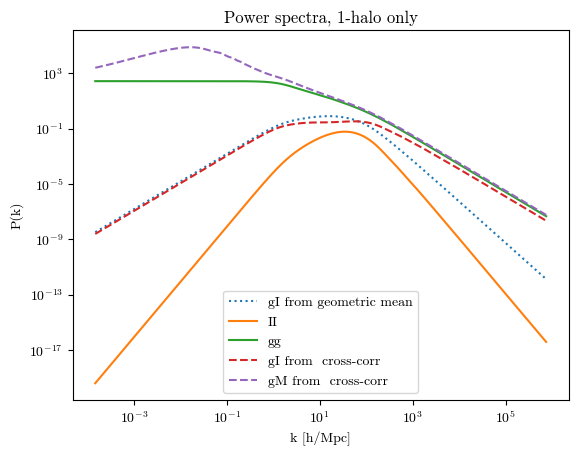

In [542]:
plt.title('Power spectra, 1-halo only')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.loglog(k_arr/cosmo['h'], 
           -pk2d_gI_geo.eval(k_arr, 1, cosmo), label='gI from geometric mean', ls=':')
plt.loglog(k_arr/cosmo['h'], 
           pk2d_II.eval(k_arr, 1, cosmo), label='II', ls='-')
plt.loglog(k_arr/cosmo['h'], 
           pk2d_gg.eval(k_arr, 1, cosmo), label='gg', ls='-')
plt.loglog(k_arr/cosmo['h'], 
           -pk2d_gI.eval(k_arr, 1, cosmo), label='gI from  cross-corr', ls='--')
plt.loglog(k_arr/cosmo['h'], 
           pk2d_gM.eval(k_arr, 1, cosmo), label='gM from  cross-corr', ls='--')
# plt.xlim([1e-3, 1e5])
# plt.ylim([1e-11, 1e5])
plt.legend()

### Propagating these forward into angular power spectra...

In [543]:
_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=year)
z_s, dndz_s, *_ = sp.zed.get_dndz_phot(gtype='source', zsmin=zsmin, zsmax=zsmax, year=year)
z_l, dndz_l, *_ = sp.zed.get_dndz_phot(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=year)

r_p = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(r_p, zleff)

-0.013823084893268228


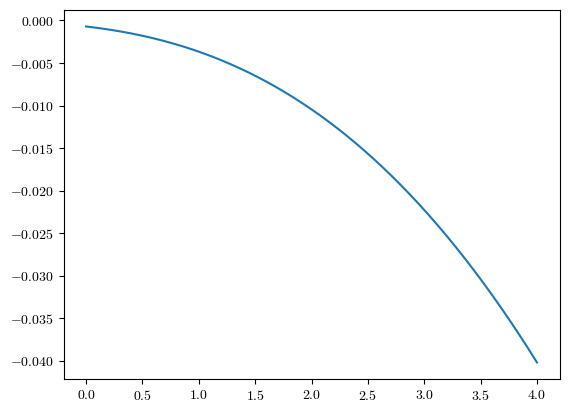

In [544]:
# values taken from DES Y3 Secco et al. Table 3
A0= 0.36
C1 = 5e-14
z0 = 0.62
n = 1.66
A_IA = -A0 * C1 * cosmo['Omega_m'] * ccl.physical_constants.RHO_CRITICAL / ccl.background.growth_factor(cosmo, 1/(1+z_s)) * ((1+z_s)/(1+z0))**n
print(np.mean(A_IA))
plt.plot(z_s, A_IA)

In [545]:
# A tracer without shear and A_ia contribution. The alignment signal is embedded in the power spectrum.
b_IA = np.ones(len(z_s))
ia_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_s, dndz_s), has_shear=False, ia_bias=(z_s, b_IA), use_A_ia=False)
# A number counts tracer for lens positions
lens_nla_tracer = ccl.NumberCountsTracer(sp.zed.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                bias=(z_l, sp.lens_bias(z_l, year=year)))

lensTracer = ccl.NumberCountsTracer(sp.zed.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                bias=(z_l, np.ones_like(z_l)))

ia_nla_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_s, dndz_s), has_shear=False, ia_bias = (z_s, A_IA), use_A_ia=False)

shearTracer = ccl.WeakLensingTracer(cosmo, (z_s, dndz_s), has_shear=True, ia_bias=None, n_samples=256)

# # convert to angular multipoles for cl calculation
#l_arr = np.unique(np.geomspace(2, 60000, 256).astype(int))
l_arr =  np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.))).astype(int)

cl_gI = ccl.angular_cl(cosmo, lensTracer, ia_tracer, l_arr, p_of_k_a = pk2d_gI)
cl_gI_NLA = ccl.angular_cl(cosmo, lens_nla_tracer, ia_nla_tracer, l_arr, p_of_k_a = None)
cl_gM = ccl.angular_cl(cosmo, lensTracer, shearTracer, l_arr, p_of_k_a = pk2d_gM)

In [546]:
#cl_gI_wind = ccl.angular_cl(cosmo, lensTracer, ia_tracer, l_arr, p_of_k_a = pk2d_gI_geo_window)
l1h = 1.4e4
l2h = 3e4
cl_gI_wind = cl_gI * (1-np.exp(-(l_arr/l1h)**2)) +  cl_gI_NLA * (np.exp(-(l_arr/l2h)**2))

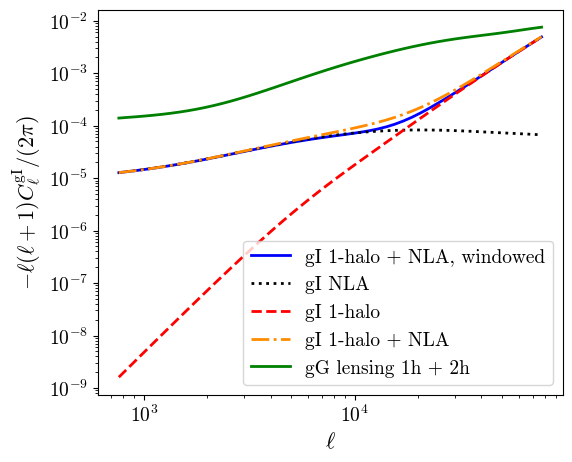

In [547]:
lfac = l_arr * (l_arr + 1) / (2 * np.pi)

plt.figure(figsize=[6,5])
plt.loglog(l_arr, lfac * -cl_gI_wind, lw=2, label='gI 1-halo + NLA, windowed', c='blue')
plt.loglog(l_arr, lfac * -cl_gI_NLA, lw=2, label='gI NLA', c='black', ls='dotted')
plt.loglog(l_arr, lfac * -cl_gI, lw=2, label='gI 1-halo', c='red', ls='dashed')
plt.loglog(l_arr, lfac * -(cl_gI + cl_gI_NLA), lw=2, label='gI 1-halo + NLA', c='darkorange', ls='-.')
plt.loglog(l_arr, lfac * cl_gM, lw=2, label='gG lensing 1h + 2h', c='green', ls='-')
plt.legend(fontsize=14)
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{gI}}/(2\pi)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('C_ell_halo+NLA.png', bbox_inches='tight', dpi=300)

### Instead define our own function to convert the angular Cl to Xi

In [548]:
from wigner import wigner_dl
from scipy.interpolate import interp1d
from tqdm import tqdm

def wigD_correlation(cosmo, l_arr, 
                    tracer1, ia_tracer1, 
                    theta,
                    lensing='GGL',
                    p_of_k_a=None,
                    window=False,
                    l1h=None,
                    l2h=None,
                    tracer2=None,
                    ia_tracer2=None,
                    pm=1, 
                    sampling=1e5, 
                    show_prog=True
                  ): 
    
    if ia_tracer2 is None:
        ia_tracer2 = ia_tracer1
    if tracer2 is None:
        tracer2 = tracer1
    
    # define a larger ell array for wigner matrix
    lmin = 1
    lmax = int(lmin + sampling)
    ell_arr_sample = np.unique(np.geomspace(lmin, lmax, 256).astype(int))
    
    # set spin values based on correlation type provided
    if lensing == 'GGL':
        sa = 2
        sb = 0
        # recompute angular cl for gI correlation
        if not window:
            Cl_sample = ccl.angular_cl(cosmo, tracer1, ia_tracer1, ell_arr_sample, p_of_k_a=p_of_k_a)
        if window:
            pk1 = p_of_k_a[0]
            pk2 = p_of_k_a[1]
            Cl_1h = ccl.angular_cl(cosmo, tracer1, ia_tracer1, ell_arr_sample, p_of_k_a=pk1)
            Cl_2h = ccl.angular_cl(cosmo, tracer2, ia_tracer2, ell_arr_sample, p_of_k_a=pk2)
            Cl_sample = (Cl_1h * (1-np.exp(-(ell_arr_sample/l1h)**2)) 
                         + Cl_2h * (np.exp(-(ell_arr_sample/l2h)**2)))
    elif lensing == 'CS':
        # TODO: Set up for full output or just IA / lensing and add
        # window function for angular Cls
        sa = 0 
        sb = 0
        # recompute angular cl as a sum of GG, GI and II terms
        if p_of_k_a is not None:
            p_GI = p_of_k_a[0]
            p_II = p_of_k_a[1]
        else:
            p_GI = None 
            p_II = None

        cl_GG = ccl.angular_cl(cosmo, tracer1, tracer1, ell_arr_sample)
        cl_GI = ccl.angular_cl(cosmo, tracer1, ia_tracer, ell_arr_sample, p_of_k_a=p_GI)
        cl_II = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, ell_arr_sample, p_of_k_a=p_II)
        Cl_sample = cl_GG+cl_GI+cl_II
    else:
        print('Not a valid correlation type')
        sys.exit()    

    # interpolate to get high density array
    ell_arr  = np.arange(lmin, lmax)
    Cl_intp = interp1d(ell_arr_sample, Cl_sample)
        
    # loop over theta values and calculate xi at each
    xi = np.zeros_like(theta)
    for th in tqdm(range(len(theta)), disable=not show_prog):
        # get wigner-d matrix for given theta
        d_ell = wigner_dl(lmin, lmax, sa, sb, np.radians(theta[th]))
        # compute xi value for given theta by summing over ell values
        xi_temp = 0
        prefactor = (2*ell_arr + 1)/(4*np.pi)
        C_ab_l = pm**(sb) * Cl_intp(ell_arr)
        xi_temp += np.sum(prefactor * C_ab_l * d_ell[:-1])
        # record result to array
        xi[th] = xi_temp
            
    return xi

In [549]:
xi_wig_wind = wigD_correlation(cosmo, l_arr, lensTracer, ia_tracer, theta/60, 
                               lensing='GGL', p_of_k_a=[pk2d_gI,None], window=True,
                               l1h=l1h, l2h=l2h, ia_tracer2=ia_nla_tracer, 
                               tracer2=lens_nla_tracer, sampling=1e7
                              )

xi_wig_NLA = wigD_correlation(cosmo=cosmo, l_arr=l_arr, tracer1=lens_nla_tracer, 
                              ia_tracer1=ia_nla_tracer, theta=theta/60, 
                              lensing='GGL', p_of_k_a=None, sampling=1e7
                             )

xi_wig_1h = wigD_correlation(cosmo, l_arr, lensTracer, ia_tracer, theta/60, 
                              lensing='GGL', p_of_k_a=pk2d_gI, sampling=1e7
                             )

shearTracer = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_s, dndz_s), has_shear=True,
                                   ia_bias=None)
# compute lensing shear
y_L = wigD_correlation(cosmo, l_arr, lensTracer, shearTracer, theta/60, 
                              lensing='GGL', p_of_k_a=pk2d_gM, sampling=1e7
                             )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.92it/s]


# Now we redo plots to show it works ( I think? )

In [550]:
Boost_dat = np.load('generated_data/boost_y%d_zs=0.05-%1.1f.npz'%(year,zsmax))
B_min1 = Boost_dat['B_min1']
r_p = Boost_dat['rp']

F_theta = np.load('generated_data/F_theta_y%d_zs=0.05-%1.1f.npz'%(year,zsmax))['F_theta']

np.savez('generated_data/F_theta_y%d_zs=0.05-%1.1f.npz'%(year,zsmax), F_theta=F_theta)

In [551]:
# multiply by maximum residual bias and divide by P.A. fraction
# define multiplicative bias uncertainty

if year==1:
    sigma_m = 0.013
elif year==10:
    sigma_m = 0.003

delM_yL = (2.*sigma_m*y_L) / (B_min1 + F_theta)
yL = y_L / (B_min1 + F_theta)

np.savez('generated_data/delM_yL_y%d_zs=%1.2f-%1.2f.npz'%(year, zsmin, zsmax), yL=y_L)

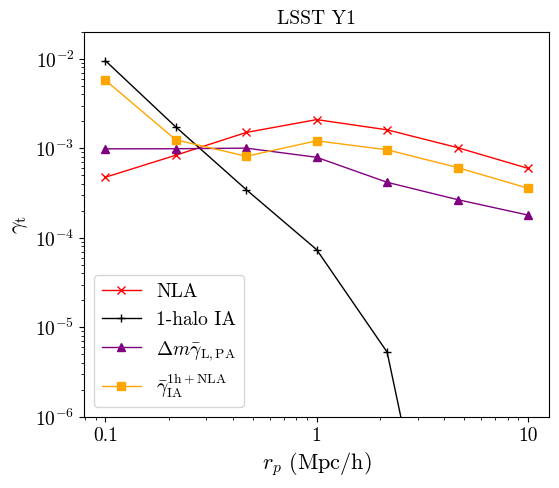

In [552]:
yIA_window = xi_wig_wind / (B_min1 + F_theta)
yIA_NLA = xi_wig_NLA / (B_min1 + F_theta)
yIA_1h = xi_wig_1h / (B_min1 + F_theta)

np.savez('generated_data/yIA_y%d_zs=%1.2f-%1.2f.npz'%(year, zsmin, zsmax), yIA = xi_wig_wind)

plt.figure(figsize=[6,5])
plt.loglog(r_p, -yIA_NLA, lw=1, c='red', marker='x', label='NLA')
plt.loglog(r_p,-yIA_1h, lw=1, marker='+', c='black', label='1-halo IA')
plt.loglog(r_p, delM_yL, lw=1, marker='^', c='purple', label=r'$\Delta m \bar{\gamma}_{\rm L,PA}$')
plt.loglog(r_p, -0.60*yIA_window, lw=1, c='orange', marker='s', label=r'$\bar{\gamma}_{\rm IA}^{\rm 1h + NLA}$')
plt.ylim([1e-6, 2e-2])
#plt.xlim([0.1, 10])
plt.yticks(fontsize=14)
plt.xticks([0.1,1,10],['0.1','1','10'], fontsize=14)
plt.ylabel(r'$\gamma_{\rm t}$', fontsize=16)
plt.xlabel(r'$r_p$ (Mpc/h)', fontsize=16)
plt.legend(fontsize=14)
plt.title('LSST Y%d'%year, fontsize=14)
plt.savefig('gamIA_NLA-vs-1h.pdf', dpi=300, bbox_inches='tight')

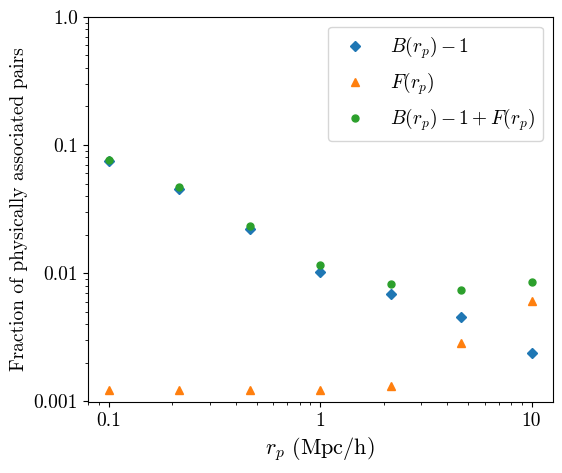

In [556]:
plt.figure(figsize=[6,5])
plt.plot(r_p, B_min1, lw=0, marker='D', markersize=5)
plt.plot(r_p, F_theta, lw=0, marker='^', markersize=6)
plt.plot(r_p, B_min1+F_theta, lw=0, marker='o', markersize=5)
plt.xscale('log')
plt.yscale('log')
#plt.ylim([0.001, 6])
plt.yticks([0.001, 0.01, 0.1, 1.0],['0.001', '0.01', '0.1', '1.0'],
          fontsize=14)
plt.xticks([0.1, 1, 10], ['0.1', '1', '10'], fontsize=14)
plt.xlabel(r'$r_p$ (Mpc/h)', fontsize=16)
plt.ylabel('Fraction of physically associated pairs', fontsize=14)
plt.legend([r'$B(r_p) - 1$', r'$F(r_p)$', r'$B(r_p) - 1 + F(r_p)$'], fontsize=14)
plt.savefig('boost_and_f.pdf', bbox_inches='tight', dpi=300)